In [27]:
import tensorflow as tf
tf.__version__
tf.config.experimental.enable_op_determinism()
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [28]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import random

In [29]:
tf.keras.backend.clear_session()

In [30]:
def plot_columns(df):
    colors = plt.cm.tab20(range(df.shape[1]))  

    for i, column in enumerate(df.columns):
        color = colors[i % 24]

        plt.figure()
        plt.plot(df.index, df[column], color=color)
        plt.xlabel('Tempo')
        plt.ylabel('Valor')
        plt.title(column)

    plt.show()

In [31]:
def plot_correlation_matrix(df):
    correlation_matrix = df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation Matrix Heatmap")
    plt.show()

In [32]:
subject = 'Roraima - Consumo de Cimento (t)'
start_index = 0
split_index = 179
window_size = 36
train_split = split_index + 1 - 12

In [33]:
data = pd.read_csv('2003_mo_model_input_RR.csv')
pd.set_option('display.max_columns', None)
data

,Unnamed: 0,Roraima - IDH,Roraima - IDH Longevidade,Roraima - Consumo de Cimento (t),Roraima- custo m2 (R$),Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Roraima - IDH Educacao,Roraima - Depósito Poupança (R$),Roraima - PIB - Estadual,Roraima - PIB - Construção Civil,Roraima - PIB - Per Capita,Roraima - PIB - Preços de Mercado,Roraima - IDH Renda,Roraima - Desemprego,Roraima - value,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%)
0,2003-1,0.734916,0.737579,6.920,12652.753600,2.058778,1001.077198,1671.347636,25.569094,22.736364,82.325261,1.614960,0.721714,137154.814617,6.128460e+06,332580.202821,12.101540,5.339136e+06,0.766811,8.263084,0.294583,384683.093871,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498
1,2003-2,0.734957,0.737903,7.476,12757.336292,2.058778,1001.079258,1671.347636,25.575369,22.731191,82.325261,1.615759,0.721974,138007.572103,6.136622e+06,332914.755543,12.103485,5.342057e+06,0.766348,8.257123,0.296505,385266.203928,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389
2,2003-3,0.734998,0.738226,8.659,12860.789996,2.058778,1001.080459,1671.347636,25.579030,22.728173,82.325261,1.616226,0.722235,138860.329589,6.144784e+06,333249.308265,12.105429,5.344978e+06,0.765885,8.251161,0.298178,385305.059560,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184
3,2003-4,0.735038,0.738550,7.259,12962.516425,2.058778,1001.080588,1671.347636,25.579422,22.727849,82.325261,1.616276,0.722495,139713.087075,6.152947e+06,333583.860987,12.107373,5.347899e+06,0.765422,8.245199,0.299598,385752.052697,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287
4,2003-5,0.735079,0.738873,6.786,13063.753666,2.047445,1001.066958,1673.953674,25.600512,22.700959,82.163288,1.626211,0.722756,140565.844561,6.161109e+06,333918.413709,12.109318,5.350821e+06,0.764958,8.239238,0.300965,387164.022451,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,2023-5,NaN,NaN,NaN,38506.140515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
245,2023-6,NaN,NaN,NaN,38458.886125,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
246,2023-7,NaN,NaN,NaN,38396.986094,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
247,2023-8,NaN,NaN,NaN,38312.397156,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


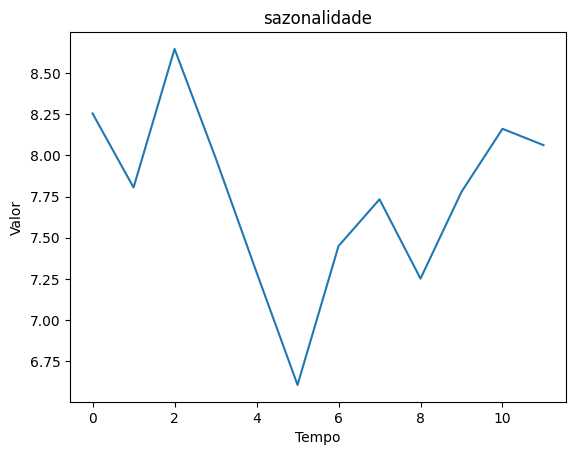

,sazonalidade
sazonalidade,
0,8.254748
1,7.805187
2,8.646925
3,7.985925
4,7.290338
5,6.606015
6,7.449672
7,7.733340
8,7.251604


In [34]:
def calculate_monthly_means(consume_of_cement, subject):
    df = pd.DataFrame({subject: consume_of_cement})
    df['sazonalidade'] = df.index % 12
    monthly_means = df.groupby('sazonalidade')[subject].mean()
    result_df = pd.DataFrame({'sazonalidade': monthly_means})

    return result_df

media_df = calculate_monthly_means(data[subject], subject)
plot_columns(media_df)
media_df

In [35]:
def fill_original_df_with_monthly_means(df_og, media_df):
    monthly_means = media_df['sazonalidade'].tolist()
    df_og['sazonalidade'] = [monthly_means[i % 12] for i in range(len(df_og))]
    return df_og

data = fill_original_df_with_monthly_means(data, media_df)
data = data[[col for col in data.columns if col != subject] + [subject]] #Seta consumo (target) para a coluna final
data

,Unnamed: 0,Roraima - IDH,Roraima - IDH Longevidade,Roraima- custo m2 (R$),Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Roraima - IDH Educacao,Roraima - Depósito Poupança (R$),Roraima - PIB - Estadual,Roraima - PIB - Construção Civil,Roraima - PIB - Per Capita,Roraima - PIB - Preços de Mercado,Roraima - IDH Renda,Roraima - Desemprego,Roraima - value,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),sazonalidade,Roraima - Consumo de Cimento (t)
0,2003-1,0.734916,0.737579,12652.753600,2.058778,1001.077198,1671.347636,25.569094,22.736364,82.325261,1.614960,0.721714,137154.814617,6.128460e+06,332580.202821,12.101540,5.339136e+06,0.766811,8.263084,0.294583,384683.093871,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498,8.254748,6.920
1,2003-2,0.734957,0.737903,12757.336292,2.058778,1001.079258,1671.347636,25.575369,22.731191,82.325261,1.615759,0.721974,138007.572103,6.136622e+06,332914.755543,12.103485,5.342057e+06,0.766348,8.257123,0.296505,385266.203928,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389,7.805187,7.476
2,2003-3,0.734998,0.738226,12860.789996,2.058778,1001.080459,1671.347636,25.579030,22.728173,82.325261,1.616226,0.722235,138860.329589,6.144784e+06,333249.308265,12.105429,5.344978e+06,0.765885,8.251161,0.298178,385305.059560,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184,8.646925,8.659
3,2003-4,0.735038,0.738550,12962.516425,2.058778,1001.080588,1671.347636,25.579422,22.727849,82.325261,1.616276,0.722495,139713.087075,6.152947e+06,333583.860987,12.107373,5.347899e+06,0.765422,8.245199,0.299598,385752.052697,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287,7.985925,7.259
4,2003-5,0.735079,0.738873,13063.753666,2.047445,1001.066958,1673.953674,25.600512,22.700959,82.163288,1.626211,0.722756,140565.844561,6.161109e+06,333918.413709,12.109318,5.350821e+06,0.764958,8.239238,0.300965,387164.022451,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538,7.290338,6.786
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,2023-5,NaN,NaN,38506.140515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.290338,NaN
245,2023-6,NaN,NaN,38458.886125,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.606015,NaN
246,2023-7,NaN,NaN,38396.986094,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.449672,NaN
247,2023-8,NaN,NaN,38312.397156,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.733340,NaN


In [36]:
# Shift para prever futuro e não presente
target_data = data[subject].shift(-24)
target_data

0      2.928
1      2.118
2      2.876
3      3.091
4      2.684
       ...  
244      NaN
245      NaN
246      NaN
247      NaN
248      NaN
Name: Roraima - Consumo de Cimento (t), Length: 249, dtype: float64

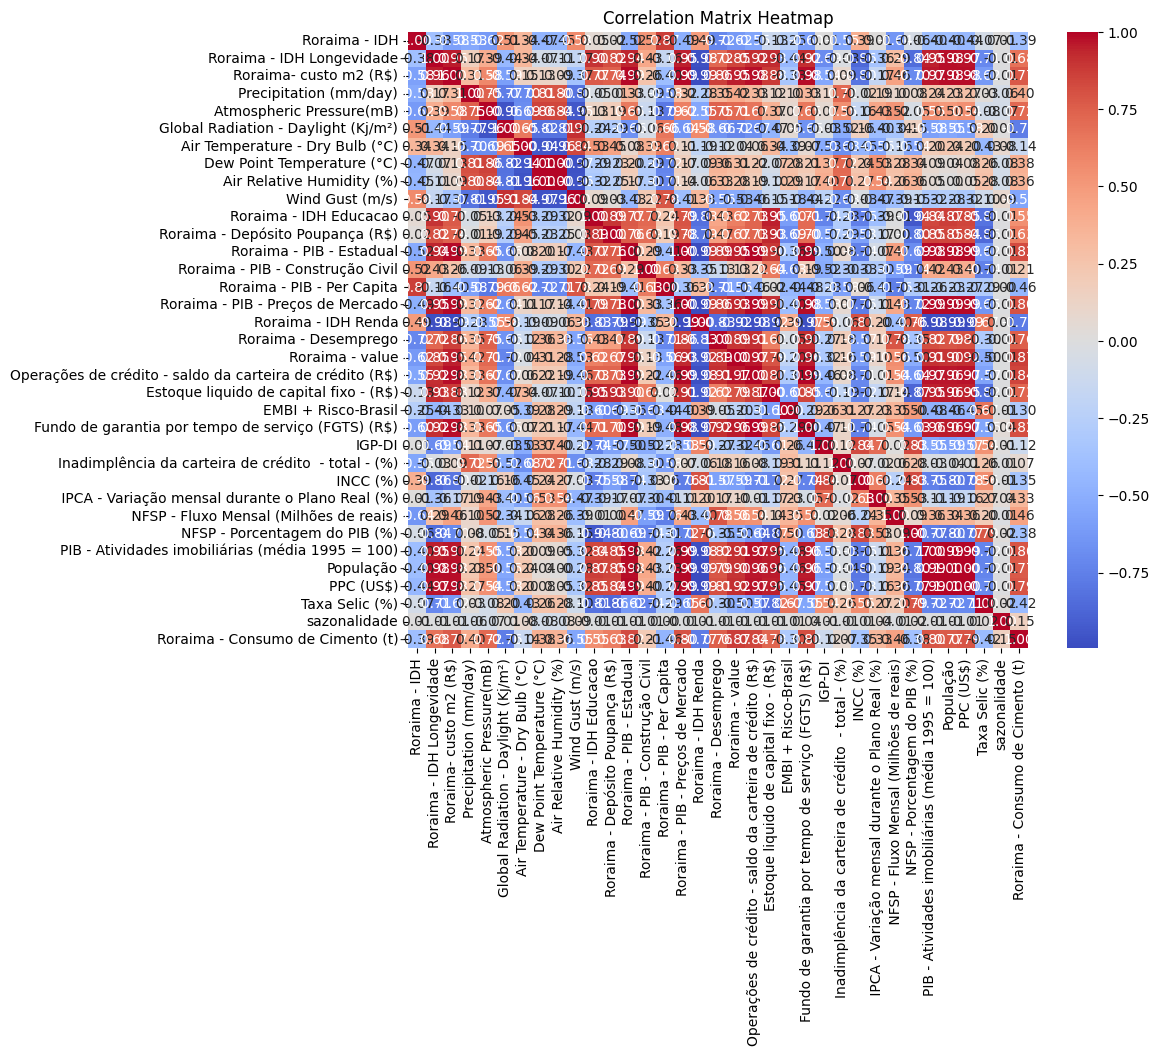

In [37]:
plot_data = data.iloc[:split_index + 1,1:]
plot_correlation_matrix(plot_data)

In [38]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

safe_data = data.iloc[:split_index + 1,1:-1]

def calculate_vif(dataframe):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = dataframe.columns
    vif_data["VIF"] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]
    return vif_data

def remove_high_vif_columns(dataframe, threshold=1000):
    i=0
    while True:
        vif_result = calculate_vif(dataframe)
        high_vif_column = vif_result.loc[vif_result["VIF"].idxmax()]["Feature"]
        
        if vif_result["VIF"].max() <= threshold:
            print(f"Num columns removed: {i}")
            return dataframe
        i += 1
        dataframe = dataframe.drop(high_vif_column, axis=1)

In [39]:
safe_data = data.iloc[:split_index + 1,1:-1]
vif_info = calculate_vif(safe_data)
vif_info

,Feature,VIF
0,Roraima - IDH,3.173744e+03
1,Roraima - IDH Longevidade,3.127937e+09
2,Roraima- custo m2 (R$),8.248609e+04
3,Precipitation (mm/day),1.775948e+01
4,Atmospheric Pressure(mB),3.457394e+02
5,Global Radiation - Daylight (Kj/m²),4.374163e+02
6,Air Temperature - Dry Bulb (°C),7.192998e+03
7,Dew Point Temperature (°C),1.835135e+04
8,Air Relative Humidity (%),7.564267e+04
9,Wind Gust (m/s),1.974503e+03


In [40]:
data =data.drop(['Air Temperature - Dry Bulb (°C)'], axis=1)
data = remove_high_vif_columns(safe_data, 1000000)
data

Num columns removed: 9


,Roraima- custo m2 (R$),Precipitation (mm/day),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Roraima - Depósito Poupança (R$),Roraima - PIB - Construção Civil,Roraima - IDH Renda,Roraima - Desemprego,Roraima - value,Operações de crédito - saldo da carteira de crédito (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),PPC (US$),Taxa Selic (%),sazonalidade
0,12652.753600,2.058778,1671.347636,25.569094,22.736364,82.325261,1.614960,137154.814617,332580.202821,0.766811,8.263084,0.294583,3.846831e+05,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,169.247665,1.611498,8.254748
1,12757.336292,2.058778,1671.347636,25.575369,22.731191,82.325261,1.615759,138007.572103,332914.755543,0.766348,8.257123,0.296505,3.852662e+05,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,170.176810,1.450389,7.805187
2,12860.789996,2.058778,1671.347636,25.579030,22.728173,82.325261,1.616226,138860.329589,333249.308265,0.765885,8.251161,0.298178,3.853051e+05,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,171.135713,1.870184,8.646925
3,12962.516425,2.058778,1671.347636,25.579422,22.727849,82.325261,1.616276,139713.087075,333583.860987,0.765422,8.245199,0.299598,3.857521e+05,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,172.116904,1.355287,7.985925
4,13063.753666,2.047445,1673.953674,25.600512,22.700959,82.163288,1.626211,140565.844561,333918.413709,0.764958,8.239238,0.300965,3.871640e+05,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,173.072271,1.585538,7.290338
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,26001.754538,2.401394,1617.294196,28.089399,21.182049,68.473283,1.654963,420496.777659,340226.550786,0.701499,10.596927,0.425379,3.068648e+06,273.655482,1.001735e+07,0.471521,3.683580,0.378150,0.366904,-5783.316460,2.206994,196.778355,416.859692,0.583985,7.733340
176,26110.990468,2.253531,1625.801444,28.341742,20.872847,66.244118,1.803534,422796.189763,340258.149767,0.701409,10.605982,0.426321,3.070265e+06,269.131737,9.868983e+06,0.476827,3.634735,0.377666,0.358935,-6001.730740,2.215328,197.255170,417.748887,0.753312,7.251604
177,26227.214207,2.061252,1633.935374,28.514515,20.367319,63.624970,1.974447,425095.601867,340289.748748,0.701319,10.615037,0.427293,3.078615e+06,265.863958,1.025520e+07,0.475427,3.545663,0.377838,0.354313,-6454.887704,2.232466,197.731985,418.601189,0.882343,7.778761
178,26339.434595,2.175937,1632.841045,28.568520,19.750882,61.142532,2.170530,427395.013971,340321.347730,0.701229,10.624092,0.428276,3.083099e+06,263.741041,1.073635e+07,0.491301,3.476080,0.370057,0.352728,-6243.191421,2.263185,198.211712,419.430070,1.004174,8.161704


In [41]:
input_data = data.iloc[:split_index + 1,1:-1]
mean = np.mean(input_data, axis=0)
stddev =  np.std(input_data, axis=0)
input_data = ((input_data - mean) /stddev)
# scaler=MinMaxScaler()
# scaled_data = scaler.fit_transform(input_data)
# input_data = pd.DataFrame(scaled_data, columns=input_data.columns)
input_data

,Precipitation (mm/day),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Roraima - Depósito Poupança (R$),Roraima - PIB - Construção Civil,Roraima - IDH Renda,Roraima - Desemprego,Roraima - value,Operações de crédito - saldo da carteira de crédito (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),PPC (US$),Taxa Selic (%)
0,0.886799,-0.314101,-1.911690,1.486423,1.528597,-1.022377,-1.890818,-2.527122,1.840391,-0.626096,-0.775860,-1.310937,-0.582539,-1.302390,3.921218,1.209036,3.214079,2.802383,0.604311,4.268118,-1.845112,-1.798021,2.127040
1,0.886799,-0.314101,-1.906953,1.483681,1.528597,-1.021462,-1.883775,-2.444919,1.816426,-0.631425,-0.741691,-1.310358,-0.792841,-1.336546,3.582946,1.203470,3.051841,2.402642,0.609431,4.096014,-1.839712,-1.785942,1.562580
2,0.886799,-0.314101,-1.904190,1.482081,1.528597,-1.020928,-1.876732,-2.362716,1.792460,-0.636754,-0.711965,-1.310320,-0.617643,-1.349731,3.422548,1.202078,2.944772,2.158351,0.562720,3.903698,-1.834313,-1.773475,3.033368
3,0.886799,-0.314101,-1.903894,1.481910,1.528597,-1.020871,-1.869689,-2.280513,1.768494,-0.642084,-0.686715,-1.309876,-0.152627,-1.352950,3.167136,1.199914,2.842174,2.049492,0.455907,3.693727,-1.828913,-1.760719,1.229384
4,0.874434,-0.303938,-1.887973,1.467656,1.516282,-1.009500,-1.862647,-2.198310,1.744528,-0.647413,-0.662422,-1.308476,0.462644,-1.345407,2.986591,1.189162,3.059587,1.905441,0.498418,3.454992,-1.822257,-1.748299,2.036088
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,1.260598,-0.524894,-0.009100,0.662522,0.475411,-0.976592,0.449256,-0.648335,-1.538904,1.460134,1.548839,1.351069,-0.193815,1.501633,-0.514871,1.296737,-1.872446,-1.429358,0.425789,-0.584804,1.266999,1.421090,-1.472938
176,1.099278,-0.491718,0.181394,0.498622,0.305924,-0.806546,0.468247,-0.640571,-1.543557,1.468228,1.565583,1.352673,-0.235540,1.449107,-0.473208,1.139013,-1.876611,-1.523783,0.339575,-0.580461,1.288102,1.432650,-0.879688
177,0.889498,-0.459998,0.311822,0.230655,0.106787,-0.610928,0.487237,-0.632807,-1.548210,1.476323,1.582863,1.360954,-0.265681,1.585840,-0.484199,0.851392,-1.875135,-1.578548,0.160702,-0.571531,1.309204,1.443731,-0.427616
178,1.014622,-0.464266,0.352590,-0.096102,-0.081957,-0.386502,0.506228,-0.625043,-1.552863,1.484417,1.600336,1.365401,-0.285262,1.756179,-0.359568,0.626702,-1.942040,-1.597335,0.244264,-0.555524,1.330436,1.454507,-0.000772


In [42]:
# input para treinamento
train_input = input_data.iloc[start_index:train_split]
train_input

,Precipitation (mm/day),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Roraima - Depósito Poupança (R$),Roraima - PIB - Construção Civil,Roraima - IDH Renda,Roraima - Desemprego,Roraima - value,Operações de crédito - saldo da carteira de crédito (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),PPC (US$),Taxa Selic (%)
0,0.886799,-0.314101,-1.911690,1.486423,1.528597,-1.022377,-1.890818,-2.527122,1.840391,-0.626096,-0.775860,-1.310937,-0.582539,-1.302390,3.921218,1.209036,3.214079,2.802383,0.604311,4.268118,-1.845112,-1.798021,2.127040
1,0.886799,-0.314101,-1.906953,1.483681,1.528597,-1.021462,-1.883775,-2.444919,1.816426,-0.631425,-0.741691,-1.310358,-0.792841,-1.336546,3.582946,1.203470,3.051841,2.402642,0.609431,4.096014,-1.839712,-1.785942,1.562580
2,0.886799,-0.314101,-1.904190,1.482081,1.528597,-1.020928,-1.876732,-2.362716,1.792460,-0.636754,-0.711965,-1.310320,-0.617643,-1.349731,3.422548,1.202078,2.944772,2.158351,0.562720,3.903698,-1.834313,-1.773475,3.033368
3,0.886799,-0.314101,-1.903894,1.481910,1.528597,-1.020871,-1.869689,-2.280513,1.768494,-0.642084,-0.686715,-1.309876,-0.152627,-1.352950,3.167136,1.199914,2.842174,2.049492,0.455907,3.693727,-1.828913,-1.760719,1.229384
4,0.874434,-0.303938,-1.887973,1.467656,1.516282,-1.009500,-1.862647,-2.198310,1.744528,-0.647413,-0.662422,-1.308476,0.462644,-1.345407,2.986591,1.189162,3.059587,1.905441,0.498418,3.454992,-1.822257,-1.748299,2.036088
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,1.539669,-0.567531,0.340201,0.565049,0.328811,-0.969523,0.285334,-0.650811,-1.476020,1.489348,1.390972,1.407354,0.731931,1.338281,-1.087000,1.252487,-1.491033,-0.960452,1.465326,-0.676734,1.091879,1.261902,0.499090
164,2.063180,-0.482618,0.613816,0.441389,0.155371,-0.853697,0.291532,-0.661186,-1.482083,1.472173,1.402104,1.402136,0.583095,1.318191,-0.904679,1.414483,-1.525186,-1.007966,1.351131,-0.668750,1.100438,1.276272,0.323875
165,1.853615,-0.536609,0.772337,0.285564,0.005712,-0.726753,0.297729,-0.671561,-1.488145,1.454999,1.412964,1.398719,0.433167,1.483470,-0.900134,1.498244,-1.546744,-0.976556,1.143146,-0.657609,1.108997,1.290351,0.198030
166,1.543154,-0.736087,0.511805,0.232911,0.043627,-0.619252,0.303927,-0.681935,-1.494207,1.437824,1.423545,1.393142,0.297965,1.703486,-1.136836,1.476356,-1.586381,-1.146834,1.542609,-0.647588,1.117113,1.304501,0.502803


In [43]:
# Alvo para treinamento
train_target = target_data.iloc[start_index:train_split]
train_target

0      2.928
1      2.118
2      2.876
3      3.091
4      2.684
       ...  
163    7.275
164    9.468
165    7.970
166    7.866
167    8.108
Name: Roraima - Consumo de Cimento (t), Length: 168, dtype: float64

In [44]:
def create_batches(t_input, t_target, window_size, start_from):
    
    X_batches = []
    y_batches = []

    train_input_values = t_input.values 

    for i in range(len(t_input) - window_size):
        
        X_window = train_input_values[i:i+window_size, :]
        y_target = t_target[start_from+i+window_size]

        X_batches.append(X_window)
        y_batches.append(y_target)

    return np.array(X_batches), np.array(y_batches)

In [45]:
reshaped_train, reshaped_target = create_batches(train_input, 
                                                 train_target, 
                                                 window_size, 
                                                 start_index)
reshaped_train.shape

(132, 36, 23)

In [46]:
# input para treinamento
test_input = input_data.iloc[train_split - window_size:split_index + 1]
test_input

,Precipitation (mm/day),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Roraima - Depósito Poupança (R$),Roraima - PIB - Construção Civil,Roraima - IDH Renda,Roraima - Desemprego,Roraima - value,Operações de crédito - saldo da carteira de crédito (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),PPC (US$),Taxa Selic (%)
132,0.293030,-0.589576,0.397799,-0.016903,-0.058665,-0.021282,0.985188,0.350031,-0.747537,1.220008,0.892491,0.992500,-0.548487,1.079517,0.174628,-1.262693,-0.066954,1.530065,0.817451,-0.366715,1.072212,0.878252,-0.590376
133,0.512835,-0.565067,0.545913,0.014636,-0.094639,-0.016689,0.959032,0.272399,-0.749767,1.249467,0.922755,1.013803,-0.501591,0.954387,0.240832,-1.257770,-0.130652,1.649361,1.130195,-0.350285,1.078438,0.887574,-0.476859
134,0.700648,-0.629075,0.436859,0.176572,0.047061,-0.143770,0.932876,0.194768,-0.751997,1.278926,0.953306,1.036490,-0.487442,0.917313,0.176857,-1.179613,-0.079602,1.622916,1.160498,-0.335122,1.084663,0.896990,-0.089952
135,0.398218,-0.659876,0.205482,0.379223,0.248358,-0.337254,0.906720,0.117136,-0.754227,1.308385,0.983035,1.059637,-0.477666,0.905701,-0.005233,-1.150081,-0.034473,1.581460,1.131990,-0.321950,1.090889,0.906245,-0.814200
136,0.703741,-1.004927,-0.381775,0.587323,0.579178,-0.674023,0.880564,0.039504,-0.756457,1.337844,1.013013,1.080606,-0.476309,0.917044,0.097576,-1.102711,-0.177535,1.638292,1.384387,-0.302995,1.095273,0.915208,-0.917944
137,0.851471,-0.862256,-0.461411,0.639851,0.644394,-0.806939,0.854408,-0.038128,-0.758687,1.367303,1.041055,1.101264,-0.468224,0.926784,0.431487,-1.100246,-0.208868,1.643773,1.375487,-0.290554,1.099656,0.924126,-0.708692
138,0.459857,-0.700197,-0.378182,0.623947,0.601345,-0.885503,0.828252,-0.115759,-0.760917,1.396762,1.069343,1.123860,-0.449308,0.951808,0.482414,-1.083821,-0.245300,1.704584,1.438928,-0.281926,1.104040,0.932114,-0.496126
139,0.468662,-0.649796,-0.251945,0.638934,0.557537,-0.919963,0.802096,-0.193391,-0.763146,1.426221,1.094347,1.150086,-0.429479,0.970898,0.657043,-1.080043,-0.333490,1.841703,1.569590,-0.275931,1.104434,0.939863,-0.251065
140,-0.073621,-0.486791,-0.025452,0.539834,0.409026,-0.830182,0.775940,-0.271023,-0.765376,1.455680,1.118813,1.179474,-0.410867,0.982071,0.678386,-1.159959,-0.296846,1.837218,1.584058,-0.271466,1.104827,0.947944,-0.593206
141,-0.533861,-0.655049,-0.036522,0.407538,0.332991,-0.705860,0.749785,-0.348655,-0.767606,1.485140,1.143311,1.214576,-0.384008,1.141593,0.727143,-1.291433,-0.292462,1.797860,1.166380,-0.273241,1.105221,0.956229,-0.100794


In [47]:
reshaped_test, reshaped_test_target = create_batches(test_input, 
                                                     target_data, 
                                                     window_size, 
                                                     train_split - window_size)
reshaped_test.shape 

(12, 36, 23)

In [48]:
def lstm_model(train_input, train_target, 
               first_layer_n_cells, 
               second_layer_n_cells,
               third_layer_n_cells,
               want_verbose=1, seed=0):
    
    if seed != 0:
        random.seed(seed)
        np.random.seed(seed)
        tf.random.set_seed(seed)
    
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=500,
        verbose=want_verbose,
        restore_best_weights=True,
        start_from_epoch=500
    )
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.005)
    
    model = tf.keras.Sequential()
    
    model.add(tf.keras.layers.LSTM(
        first_layer_n_cells,
        activation='tanh',
        return_sequences=True,
        kernel_regularizer=tf.keras.regularizers.l2(0.01),
        input_shape=(train_input.shape[1], train_input.shape[2])
    ))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.LSTM(
        second_layer_n_cells,
        activation='tanh',
        return_sequences=(third_layer_n_cells > 0),
        kernel_regularizer=tf.keras.regularizers.l2(0.01)
    ))
        
    if third_layer_n_cells > 0:
        model.add(tf.keras.layers.Dropout(0.1))
        model.add(tf.keras.layers.LSTM(
            third_layer_n_cells,
            activation='tanh',
            kernel_regularizer=tf.keras.regularizers.l2(0.01)
        ))
        
    model.add(tf.keras.layers.Dense(1))
    
    model.compile(optimizer=optimizer, loss='mean_squared_error')    
    history = model.fit(
        train_input,
        train_target,
        epochs=10000,
        validation_split=0.07,
        callbacks=[early_stopping],
        verbose=want_verbose
    )
    
    return model, history

In [49]:
def get_a_good_seed(train_input, train_target, first_layer_n_cells, second_layer_n_cells, third_layer_n_cells):

    random_seeds = [random.randint(0, 2**32 - 1) for _ in range(3)]
    list_loss = []
    best_loss = float('inf')
    winner_seed = None
    i = 0
    for seed in random_seeds:
        print(f"\n\nStep: {i} ___________________________________________")
        i += 1

        model, history = lstm_model(train_input, train_target, 
                                    first_layer_n_cells, second_layer_n_cells, third_layer_n_cells,
                                    want_verbose=0, seed=seed)
        
        current_loss = min(history.history['val_loss'][500:])
        list_loss.append(current_loss)
        print(f"val_loss: {current_loss}")
        if current_loss < best_loss:
            best_loss = current_loss
            winner_seed = seed
            print(f"winner_seed: {winner_seed}")
            if winner_seed == 0.0:
                return winner_seed, np.mean(list_loss)

    return winner_seed, np.mean(sorted(list_loss)[:2])

In [50]:
# Tuning range
first_layer_cells_list = [36, 72, 144]
second_layer_cells_list = [36, 72, 144]
third_layer_cells_list = [0, 36, 72, 144]

In [51]:
def hyperparameter_tuning(train_input, train_target, 
                          first_layer_cells_list, second_layer_cells_list, third_layer_cells_list):
    
    best_loss = float('inf')
    best_combination = None
    
    for first_cells in first_layer_cells_list:
        for second_cells in second_layer_cells_list:
            for third_cells in third_layer_cells_list:
                if not third_cells > second_cells:
                    print(f"_________________________________________________________________________________________")
                    print(" ")
                    print(f" Testing [{first_cells}, {second_cells}, {third_cells}]")
                    print(f"_________________________________________________________________________________________")

                    winner_seed, mean_loss = get_a_good_seed(train_input, train_target, 
                                                                first_cells, second_cells, third_cells)
                    print(" ")
                    print(f"first_layer_n_cells: {first_cells}")
                    print(f"second_layer_n_cells: {second_cells}")
                    print(f"third_layer_n_cells: {third_cells}")
                    if mean_loss < best_loss:
                        best_loss = mean_loss
                        best_combination = [first_cells, second_cells, third_cells, winner_seed]
                        print(f"best_loss: {best_loss}")
                        print(f"winner_seed: {winner_seed}")
                    print(" ")
            
    return best_combination

In [52]:
best_combination = hyperparameter_tuning(reshaped_train, 
                                         reshaped_target, 
                                         first_layer_cells_list, 
                                         second_layer_cells_list, 
                                         third_layer_cells_list)
best_combination

_________________________________________________________________________________________
 
 Testing [36, 36, 0]
_________________________________________________________________________________________


Step: 0 ___________________________________________
val_loss: 1.4570441246032715
winner_seed: 128607123


Step: 1 ___________________________________________
val_loss: 1.2711981534957886
winner_seed: 106496886


Step: 2 ___________________________________________
val_loss: 1.9855953454971313
 
first_layer_n_cells: 36
second_layer_n_cells: 36
third_layer_n_cells: 0
best_loss: 1.36412113904953
winner_seed: 106496886
 
_________________________________________________________________________________________
 
 Testing [36, 36, 36]
_________________________________________________________________________________________


Step: 0 ___________________________________________
val_loss: 2.4623498916625977
winner_seed: 2624146040


Step: 1 ___________________________________________
val_loss: 

val_loss: 1.6990272998809814
winner_seed: 3111094581


Step: 1 ___________________________________________
val_loss: 1.3688685894012451
winner_seed: 3829713380


Step: 2 ___________________________________________
val_loss: 2.3673853874206543
 
first_layer_n_cells: 72
second_layer_n_cells: 144
third_layer_n_cells: 0
 
_________________________________________________________________________________________
 
 Testing [72, 144, 36]
_________________________________________________________________________________________


Step: 0 ___________________________________________
val_loss: 1.4947400093078613
winner_seed: 1011482314


Step: 1 ___________________________________________
val_loss: 1.8810125589370728


Step: 2 ___________________________________________
val_loss: 1.5159571170806885
 
first_layer_n_cells: 72
second_layer_n_cells: 144
third_layer_n_cells: 36
 
_________________________________________________________________________________________
 
 Testing [72, 144, 72]
_________

[36, 144, 144, 1626395895]

In [53]:
best_combination

[36, 144, 144, 1626395895]

In [54]:
trained_model, history = lstm_model(reshaped_train, 
                                    reshaped_target,
                                    best_combination[0], best_combination[1], best_combination[2],
                                    want_verbose=1, 
                                    seed=best_combination[3])

Epoch 1/10000
4/4 [==============================] - 4s 187ms/step - loss: 46.0810 - val_loss: 9.2854
Epoch 2/10000
4/4 [==============================] - 0s 16ms/step - loss: 8.0161 - val_loss: 7.7955
Epoch 3/10000
4/4 [==============================] - 0s 16ms/step - loss: 6.3913 - val_loss: 10.3774
Epoch 4/10000
4/4 [==============================] - 0s 15ms/step - loss: 5.7899 - val_loss: 7.3127
Epoch 5/10000
4/4 [==============================] - 0s 16ms/step - loss: 5.6752 - val_loss: 6.9353
Epoch 6/10000
4/4 [==============================] - 0s 15ms/step - loss: 5.2412 - val_loss: 6.2187
Epoch 7/10000
4/4 [==============================] - 0s 16ms/step - loss: 4.6809 - val_loss: 4.2692
Epoch 8/10000
4/4 [==============================] - 0s 15ms/step - loss: 4.3094 - val_loss: 5.3724
Epoch 9/10000
4/4 [==============================] - 0s 16ms/step - loss: 4.3402 - val_loss: 3.6997
Epoch 10/10000
4/4 [==============================] - 0s 15ms/step - loss: 4.0715 - val_loss: 5.1

4/4 [==============================] - 0s 14ms/step - loss: 2.0110 - val_loss: 6.4150
Epoch 83/10000
4/4 [==============================] - 0s 13ms/step - loss: 1.8986 - val_loss: 7.0274
Epoch 84/10000
4/4 [==============================] - 0s 15ms/step - loss: 1.8105 - val_loss: 7.0993
Epoch 85/10000
4/4 [==============================] - 0s 15ms/step - loss: 2.0613 - val_loss: 6.9556
Epoch 86/10000
4/4 [==============================] - 0s 13ms/step - loss: 1.8098 - val_loss: 5.3572
Epoch 87/10000
4/4 [==============================] - 0s 13ms/step - loss: 1.8518 - val_loss: 6.7933
Epoch 88/10000
4/4 [==============================] - 0s 13ms/step - loss: 1.7864 - val_loss: 8.3504
Epoch 89/10000
4/4 [==============================] - 0s 13ms/step - loss: 1.7876 - val_loss: 8.9133
Epoch 90/10000
4/4 [==============================] - 0s 13ms/step - loss: 1.7642 - val_loss: 7.9672
Epoch 91/10000
4/4 [==============================] - 0s 15ms/step - loss: 1.9988 - val_loss: 6.9811
Epoch

4/4 [==============================] - 0s 15ms/step - loss: 1.9835 - val_loss: 1.7744
Epoch 163/10000
4/4 [==============================] - 0s 16ms/step - loss: 1.8298 - val_loss: 1.7175
Epoch 164/10000
4/4 [==============================] - 0s 14ms/step - loss: 2.0575 - val_loss: 2.0516
Epoch 165/10000
4/4 [==============================] - 0s 14ms/step - loss: 1.8628 - val_loss: 1.6779
Epoch 166/10000
4/4 [==============================] - 0s 14ms/step - loss: 1.9052 - val_loss: 2.0165
Epoch 167/10000
4/4 [==============================] - 0s 15ms/step - loss: 1.8776 - val_loss: 1.7010
Epoch 168/10000
4/4 [==============================] - 0s 14ms/step - loss: 1.8691 - val_loss: 1.7897
Epoch 169/10000
4/4 [==============================] - 0s 15ms/step - loss: 1.7610 - val_loss: 1.7695
Epoch 170/10000
4/4 [==============================] - 0s 15ms/step - loss: 1.7313 - val_loss: 1.6901
Epoch 171/10000
4/4 [==============================] - 0s 15ms/step - loss: 1.7202 - val_loss: 1.6

4/4 [==============================] - 0s 14ms/step - loss: 1.3775 - val_loss: 2.6467
Epoch 243/10000
4/4 [==============================] - 0s 16ms/step - loss: 1.2676 - val_loss: 2.1092
Epoch 244/10000
4/4 [==============================] - 0s 13ms/step - loss: 1.3778 - val_loss: 2.5988
Epoch 245/10000
4/4 [==============================] - 0s 15ms/step - loss: 1.3288 - val_loss: 2.6402
Epoch 246/10000
4/4 [==============================] - 0s 15ms/step - loss: 1.2022 - val_loss: 2.7782
Epoch 247/10000
4/4 [==============================] - 0s 15ms/step - loss: 1.1307 - val_loss: 3.5458
Epoch 248/10000
4/4 [==============================] - 0s 16ms/step - loss: 1.2031 - val_loss: 3.5273
Epoch 249/10000
4/4 [==============================] - 0s 15ms/step - loss: 1.1903 - val_loss: 3.2533
Epoch 250/10000
4/4 [==============================] - 0s 15ms/step - loss: 1.1486 - val_loss: 4.1237
Epoch 251/10000
4/4 [==============================] - 0s 16ms/step - loss: 1.0949 - val_loss: 3.5

4/4 [==============================] - 0s 16ms/step - loss: 1.2497 - val_loss: 5.5418
Epoch 323/10000
4/4 [==============================] - 0s 13ms/step - loss: 1.0628 - val_loss: 6.2989
Epoch 324/10000
4/4 [==============================] - 0s 16ms/step - loss: 0.9928 - val_loss: 4.9589
Epoch 325/10000
4/4 [==============================] - 0s 15ms/step - loss: 1.0483 - val_loss: 6.0851
Epoch 326/10000
4/4 [==============================] - 0s 15ms/step - loss: 0.9523 - val_loss: 5.5169
Epoch 327/10000
4/4 [==============================] - 0s 15ms/step - loss: 1.1379 - val_loss: 5.3369
Epoch 328/10000
4/4 [==============================] - 0s 15ms/step - loss: 1.1363 - val_loss: 5.9708
Epoch 329/10000
4/4 [==============================] - 0s 14ms/step - loss: 1.0603 - val_loss: 5.4560
Epoch 330/10000
4/4 [==============================] - 0s 14ms/step - loss: 1.0432 - val_loss: 6.1406
Epoch 331/10000
4/4 [==============================] - 0s 14ms/step - loss: 1.0819 - val_loss: 5.7

4/4 [==============================] - 0s 15ms/step - loss: 1.1226 - val_loss: 5.9756
Epoch 403/10000
4/4 [==============================] - 0s 15ms/step - loss: 1.0810 - val_loss: 6.9865
Epoch 404/10000
4/4 [==============================] - 0s 15ms/step - loss: 0.9496 - val_loss: 6.9486
Epoch 405/10000
4/4 [==============================] - 0s 15ms/step - loss: 0.8570 - val_loss: 5.6102
Epoch 406/10000
4/4 [==============================] - 0s 15ms/step - loss: 0.9401 - val_loss: 5.2393
Epoch 407/10000
4/4 [==============================] - 0s 14ms/step - loss: 0.8903 - val_loss: 6.4629
Epoch 408/10000
4/4 [==============================] - 0s 15ms/step - loss: 0.8063 - val_loss: 7.4440
Epoch 409/10000
4/4 [==============================] - 0s 15ms/step - loss: 0.8527 - val_loss: 6.4782
Epoch 410/10000
4/4 [==============================] - 0s 15ms/step - loss: 0.8365 - val_loss: 6.2689
Epoch 411/10000
4/4 [==============================] - 0s 15ms/step - loss: 0.7935 - val_loss: 7.2

4/4 [==============================] - 0s 17ms/step - loss: 1.7869 - val_loss: 2.2461
Epoch 483/10000
4/4 [==============================] - 0s 16ms/step - loss: 1.6737 - val_loss: 2.1305
Epoch 484/10000
4/4 [==============================] - 0s 15ms/step - loss: 1.3372 - val_loss: 2.0064
Epoch 485/10000
4/4 [==============================] - 0s 15ms/step - loss: 1.3208 - val_loss: 2.2958
Epoch 486/10000
4/4 [==============================] - 0s 16ms/step - loss: 1.2759 - val_loss: 2.7623
Epoch 487/10000
4/4 [==============================] - 0s 15ms/step - loss: 1.2612 - val_loss: 2.9044
Epoch 488/10000
4/4 [==============================] - 0s 16ms/step - loss: 1.2548 - val_loss: 3.8794
Epoch 489/10000
4/4 [==============================] - 0s 16ms/step - loss: 1.1594 - val_loss: 5.4713
Epoch 490/10000
4/4 [==============================] - 0s 16ms/step - loss: 1.0515 - val_loss: 5.6208
Epoch 491/10000
4/4 [==============================] - 0s 16ms/step - loss: 1.1208 - val_loss: 4.9

4/4 [==============================] - 0s 15ms/step - loss: 1.0442 - val_loss: 4.6769
Epoch 563/10000
4/4 [==============================] - 0s 15ms/step - loss: 0.9360 - val_loss: 4.5043
Epoch 564/10000
4/4 [==============================] - 0s 16ms/step - loss: 0.8623 - val_loss: 3.7383
Epoch 565/10000
4/4 [==============================] - 0s 16ms/step - loss: 0.9005 - val_loss: 4.1807
Epoch 566/10000
4/4 [==============================] - 0s 14ms/step - loss: 0.9413 - val_loss: 4.1610
Epoch 567/10000
4/4 [==============================] - 0s 16ms/step - loss: 0.9270 - val_loss: 4.2112
Epoch 568/10000
4/4 [==============================] - 0s 15ms/step - loss: 0.9785 - val_loss: 3.9071
Epoch 569/10000
4/4 [==============================] - 0s 15ms/step - loss: 1.0503 - val_loss: 4.3924
Epoch 570/10000
4/4 [==============================] - 0s 15ms/step - loss: 0.9181 - val_loss: 4.1015
Epoch 571/10000
4/4 [==============================] - 0s 15ms/step - loss: 0.9597 - val_loss: 4.0

4/4 [==============================] - 0s 16ms/step - loss: 0.9150 - val_loss: 4.4093
Epoch 643/10000
4/4 [==============================] - 0s 15ms/step - loss: 0.8726 - val_loss: 4.1465
Epoch 644/10000
4/4 [==============================] - 0s 15ms/step - loss: 0.7695 - val_loss: 4.2586
Epoch 645/10000
4/4 [==============================] - 0s 15ms/step - loss: 0.9027 - val_loss: 4.0626
Epoch 646/10000
4/4 [==============================] - 0s 15ms/step - loss: 0.8888 - val_loss: 3.9838
Epoch 647/10000
4/4 [==============================] - 0s 15ms/step - loss: 1.1047 - val_loss: 3.6703
Epoch 648/10000
4/4 [==============================] - 0s 15ms/step - loss: 0.8589 - val_loss: 3.6993
Epoch 649/10000
4/4 [==============================] - 0s 15ms/step - loss: 1.0746 - val_loss: 3.4748
Epoch 650/10000
4/4 [==============================] - 0s 16ms/step - loss: 0.9731 - val_loss: 3.1058
Epoch 651/10000
4/4 [==============================] - 0s 15ms/step - loss: 0.9390 - val_loss: 3.5

4/4 [==============================] - 0s 15ms/step - loss: 1.1541 - val_loss: 2.4258
Epoch 723/10000
4/4 [==============================] - 0s 15ms/step - loss: 0.9367 - val_loss: 1.8010
Epoch 724/10000
4/4 [==============================] - 0s 15ms/step - loss: 0.9625 - val_loss: 1.7883
Epoch 725/10000
4/4 [==============================] - 0s 15ms/step - loss: 0.9309 - val_loss: 1.9806
Epoch 726/10000
4/4 [==============================] - 0s 15ms/step - loss: 1.1550 - val_loss: 2.4216
Epoch 727/10000
4/4 [==============================] - 0s 16ms/step - loss: 1.0722 - val_loss: 1.1430
Epoch 728/10000
4/4 [==============================] - 0s 15ms/step - loss: 1.0689 - val_loss: 0.7301
Epoch 729/10000
4/4 [==============================] - 0s 15ms/step - loss: 1.0796 - val_loss: 1.0722
Epoch 730/10000
4/4 [==============================] - 0s 16ms/step - loss: 0.9553 - val_loss: 1.3269
Epoch 731/10000
4/4 [==============================] - 0s 15ms/step - loss: 0.9036 - val_loss: 1.3

4/4 [==============================] - 0s 16ms/step - loss: 0.9306 - val_loss: 1.5893
Epoch 803/10000
4/4 [==============================] - 0s 16ms/step - loss: 0.9651 - val_loss: 1.8906
Epoch 804/10000
4/4 [==============================] - 0s 16ms/step - loss: 0.9756 - val_loss: 2.2411
Epoch 805/10000
4/4 [==============================] - 0s 15ms/step - loss: 0.9627 - val_loss: 2.0551
Epoch 806/10000
4/4 [==============================] - 0s 16ms/step - loss: 1.0875 - val_loss: 1.8754
Epoch 807/10000
4/4 [==============================] - 0s 16ms/step - loss: 1.0664 - val_loss: 2.2771
Epoch 808/10000
4/4 [==============================] - 0s 15ms/step - loss: 0.8990 - val_loss: 2.1833
Epoch 809/10000
4/4 [==============================] - 0s 16ms/step - loss: 0.8849 - val_loss: 2.2608
Epoch 810/10000
4/4 [==============================] - 0s 15ms/step - loss: 0.9345 - val_loss: 2.5372
Epoch 811/10000
4/4 [==============================] - 0s 14ms/step - loss: 0.9178 - val_loss: 2.4

4/4 [==============================] - 0s 15ms/step - loss: 0.8701 - val_loss: 3.4922
Epoch 883/10000
4/4 [==============================] - 0s 15ms/step - loss: 0.8114 - val_loss: 4.3154
Epoch 884/10000
4/4 [==============================] - 0s 15ms/step - loss: 0.8506 - val_loss: 3.7085
Epoch 885/10000
4/4 [==============================] - 0s 15ms/step - loss: 0.8153 - val_loss: 5.1079
Epoch 886/10000
4/4 [==============================] - 0s 15ms/step - loss: 0.7019 - val_loss: 4.2476
Epoch 887/10000
4/4 [==============================] - 0s 16ms/step - loss: 0.7782 - val_loss: 3.5828
Epoch 888/10000
4/4 [==============================] - 0s 16ms/step - loss: 0.8230 - val_loss: 4.3088
Epoch 889/10000
4/4 [==============================] - 0s 16ms/step - loss: 0.7623 - val_loss: 4.1924
Epoch 890/10000
4/4 [==============================] - 0s 15ms/step - loss: 0.8274 - val_loss: 4.7207
Epoch 891/10000
4/4 [==============================] - 0s 15ms/step - loss: 0.8389 - val_loss: 4.6

4/4 [==============================] - 0s 15ms/step - loss: 0.6809 - val_loss: 7.6490
Epoch 963/10000
4/4 [==============================] - 0s 16ms/step - loss: 0.8361 - val_loss: 6.1160
Epoch 964/10000
4/4 [==============================] - 0s 16ms/step - loss: 0.8651 - val_loss: 6.1685
Epoch 965/10000
4/4 [==============================] - 0s 16ms/step - loss: 0.9755 - val_loss: 7.2907
Epoch 966/10000
4/4 [==============================] - 0s 15ms/step - loss: 0.8630 - val_loss: 9.6675
Epoch 967/10000
4/4 [==============================] - 0s 15ms/step - loss: 0.9386 - val_loss: 6.8909
Epoch 968/10000
4/4 [==============================] - 0s 16ms/step - loss: 0.8721 - val_loss: 8.2706
Epoch 969/10000
4/4 [==============================] - 0s 16ms/step - loss: 1.1001 - val_loss: 6.4801
Epoch 970/10000
4/4 [==============================] - 0s 15ms/step - loss: 1.0584 - val_loss: 6.0422
Epoch 971/10000
4/4 [==============================] - 0s 15ms/step - loss: 1.0680 - val_loss: 5.3

4/4 [==============================] - 0s 15ms/step - loss: 0.5157 - val_loss: 8.5091
Epoch 1043/10000
4/4 [==============================] - 0s 16ms/step - loss: 0.5398 - val_loss: 8.5363
Epoch 1044/10000
4/4 [==============================] - 0s 14ms/step - loss: 0.4734 - val_loss: 8.0827
Epoch 1045/10000
4/4 [==============================] - 0s 15ms/step - loss: 0.5393 - val_loss: 6.4065
Epoch 1046/10000
4/4 [==============================] - 0s 15ms/step - loss: 0.9300 - val_loss: 6.8315
Epoch 1047/10000
4/4 [==============================] - 0s 15ms/step - loss: 1.0689 - val_loss: 6.4100
Epoch 1048/10000
4/4 [==============================] - 0s 15ms/step - loss: 0.9119 - val_loss: 8.1073
Epoch 1049/10000
4/4 [==============================] - 0s 15ms/step - loss: 0.7943 - val_loss: 7.8683
Epoch 1050/10000
4/4 [==============================] - 0s 15ms/step - loss: 0.8343 - val_loss: 8.5177
Epoch 1051/10000
4/4 [==============================] - 0s 14ms/step - loss: 0.8665 - val_

4/4 [==============================] - 0s 14ms/step - loss: 1.5585 - val_loss: 6.0972
Epoch 1122/10000
4/4 [==============================] - 0s 15ms/step - loss: 1.4595 - val_loss: 5.5258
Epoch 1123/10000
4/4 [==============================] - 0s 17ms/step - loss: 1.4735 - val_loss: 5.8594
Epoch 1124/10000
4/4 [==============================] - 0s 14ms/step - loss: 1.4681 - val_loss: 6.0391
Epoch 1125/10000
4/4 [==============================] - 0s 15ms/step - loss: 1.5319 - val_loss: 5.6421
Epoch 1126/10000
4/4 [==============================] - 0s 14ms/step - loss: 1.4744 - val_loss: 6.4628
Epoch 1127/10000
4/4 [==============================] - 0s 14ms/step - loss: 1.4844 - val_loss: 5.7354
Epoch 1128/10000
4/4 [==============================] - 0s 15ms/step - loss: 1.5392 - val_loss: 6.8941
Epoch 1129/10000
4/4 [==============================] - 0s 15ms/step - loss: 1.6585 - val_loss: 4.6502
Epoch 1130/10000
4/4 [==============================] - 0s 15ms/step - loss: 1.7385 - val_

4/4 [==============================] - 0s 15ms/step - loss: 1.1721 - val_loss: 7.8065
Epoch 1201/10000
4/4 [==============================] - 0s 15ms/step - loss: 1.1312 - val_loss: 7.5431
Epoch 1202/10000
4/4 [==============================] - 0s 15ms/step - loss: 1.1242 - val_loss: 8.1350
Epoch 1203/10000
4/4 [==============================] - 0s 14ms/step - loss: 1.1784 - val_loss: 7.7550
Epoch 1204/10000
4/4 [==============================] - 0s 16ms/step - loss: 1.1300 - val_loss: 6.9817
Epoch 1205/10000
4/4 [==============================] - 0s 15ms/step - loss: 1.1431 - val_loss: 8.3167
Epoch 1206/10000
4/4 [==============================] - 0s 16ms/step - loss: 1.1328 - val_loss: 8.6939
Epoch 1207/10000
4/4 [==============================] - 0s 14ms/step - loss: 1.1322 - val_loss: 8.2278
Epoch 1208/10000
4/4 [==============================] - 0s 17ms/step - loss: 1.1017 - val_loss: 7.3770
Epoch 1209/10000
4/4 [==============================] - 0s 16ms/step - loss: 1.0739 - val_

In [55]:
def mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    results_data = []

    for i in range(len(test_target)):
        prediction = model.predict(test_input[i:i+1])
        target = test_target[start_target + i]
        error = np.abs(prediction - target)
        errors.append(error)
        error_percent.append(error/target)
        results_data.append([f"Month-{i + 1}", 
                             prediction[0][0], 
                             target, 
                             error[0][0]])

    df_results = pd.DataFrame(results_data, columns=["Month", "Prediction", "Target", "Error"])

    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return df_results, mae, mape

In [56]:
df_results, mae, mape = mae_mape_calculator(trained_model, 
                                            reshaped_test, 
                                            reshaped_test_target, 
                                            start_index)
pd.set_option('display.max_columns', None)
df_results.T

1/1 [==============================] - 0s 15ms/step


,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,10.441109,11.247269,11.190165,10.948425,10.565837,10.042917,9.791441,9.858238,9.970165,10.047201,10.14754,10.299814
Target,9.908,10.723,10.625,10.593,10.681,7.887,9.751,9.654,9.422,11.16,10.491,10.225
Error,0.533109,0.524269,0.565165,0.355425,0.115163,2.155917,0.040441,0.204238,0.548165,1.112799,0.34346,0.074814


In [57]:
display(mae)
display(mape)

0.54774696

0.05806886